## Fetch clean MUPS valve temperature telemetry

This notebook provides a new function to fetch cleaned MUPS valve temperature telemetry.

It makes use of the temperature correction code provided by Scott Blanchard (to correct
for a resistor dropout in the thermistor data) and xija thermal model developed by
Matt Dahmer.

The basic cleaning algorithm is very simple:

- Fetch raw telemetry from the cheta archive.
- Compute a xija thermal model prediction for the same timespan (actually starting a few
  days in advance to burn out uncertainty in the pseudo-node value).
- Accept either raw telemetry or corrected data which are within a tolerance (5 degF) of 
  the model.
- In the gaps where the model diverges from both raw and corrected temperatures, 
  "repropagate" the model starting from the last accepted temperature value.
  This effectively takes out much of the systematic model error, which can be up to 
  15 degF after a transition to a new attitude.
- In some cases this allows recovery of additional data, while in others the data are
  not recoverable: either due to partial disconnect of the parallel resistor or full
  disconnects where the output voltage exceeds 5.12 V.

The output of this function is a `fetch.Msid` object with some bonus attributes, 
documented below.  In particular the output cleaned data are labeled so one knows
exactly where each data point came from.

The function is fast, and one can get 5 years of cleaned telemetry in a few seconds
on a modern laptop with SSD drive.
  
This cleaning technique recovers on average about 90% of data for PM2THV1T.  Since
2015, about 60% of telemetry is good (no dropout) while 30% is in a recoverable
fully-dropped state (and 10% is not recoverable).

```
def fetch_clean_msid(msid, start, stop=None, dt_thresh=5.0, median=7, model_spec=None):

    Fetch a cleaned version of telemetry for ``msid``.

    If not supplied the model spec will be downloaded from github using this URL:
      https://raw.githubusercontent.com/sot/chandra_models/master/chandra_models/xija/
              mups_valve/{msid}_spec.json
            
    This function returns a `fetch.Msid` object like a normal fetch but with extra attributes:

    - vals: cleaned telemetry (either original or corrected telemetry, or xija model prediction)
    - source: label for each vals data point
      - 0: unrecoverable, so use xija model value
      - 1: original telemetry
      - 2: corrected telemetry
    - vals_raw: raw (uncleaned) telemetry
    - vals_nan: cleaned telem but with np.nan at points where data are unrecoverable (this is
                for plotting)
    - vals_corr: telemetry with the MUPS correction applied
    - vals_model: xija model prediction
    
    :param start: start time
    :param stop: stop time (default=NOW)
    :param dt_thresh: tolerance for matching model to data in degF (default=5 degF)
    :param median: length of median filter (default=7, use 0 to disable)
    :param model_spec: file name or URL containing relevant xija model spec
    
    :returns: fetch.Msid object
```

In [1]:
import os

import numpy as np
import numba
from astropy.utils.data import download_file, get_file_contents
import matplotlib.pyplot as plt
import matplotlib.style
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
matplotlib.style.use('bmh')
%matplotlib notebook

from cheta import fetch_eng
from xija import XijaModel
from Ska.Matplotlib import plot_cxctime

In [2]:
def c2f(degc):
    degf = 32 + degc * 1.8
    return degf

In [3]:
# Define MUPS valve thermistor point pair calibration table (from TDB).
pp_counts = np.array([0, 27, 36, 44, 55, 70, 90, 118, 175, 195, 210, 219, 226, 231, 235, 255])
pp_temps = np.array([369.5305, 263.32577, 239.03652, 222.30608, 203.6944, 183.2642, 161.0796, 134.93818, 
                     85.65725, 65.6537,47.3176, 33.50622, 19.9373, 7.42435, -5.79635, -111.77265])
 
count_to_degf = interp1d(pp_counts, pp_temps)
degf_to_counts = interp1d(pp_temps, pp_counts)

# Define MUPS valve thermistor voltage point pair calibration table.
count_to_volts = lambda counts: counts / 256 * 5.12
volts_to_counts = lambda volts: volts / 5.12 * 256

# Voltage and Temperature, with and without resistor (see flight note 447 for
# the source of these numbers).

volt_with_resistor = [4.153325779, 3.676396578, 3.175100371, 2.587948965, 2.435, 2.025223702, 
                      1.538506813, 1.148359251,0.63128179, 0.354868907, 0.208375569]
volt_without_resistor = [28.223, 15, 9.1231, 5.5228, 4.87, 3.467, 2.249, 1.5027, 0.7253, 0.38276, 0.21769]
temp_without_resistor = [50, 77, 100, 125, 130, 150, 175, 200, 250, 300, 350]

volt_without_resistor_to_temp_without_resistor = interp1d(volt_without_resistor, temp_without_resistor)
temp_without_resistor_to_volt_without_resistor = interp1d(temp_without_resistor, volt_without_resistor)
volt_with_resistor_to_volt_without_resistor = interp1d(volt_with_resistor, volt_without_resistor)
volt_without_resistor_to_volt_with_resistor = interp1d(volt_without_resistor, volt_with_resistor)

def get_corr_mups_temp(temp):
    """ Calculate a MUPS valve thermistor corrected temperature.
    Args:
        temp (float, int): Temperature in Fahrenheit to which a correction will be applied.

    Returns:
        (float): Corrected temperaure

    """
    # Convert observed temperature to voltage
    count = degf_to_counts(temp)
    volt = count_to_volts(count)

    # Convert voltage as read, assuming no resistor, to what it would be with the resistor
    new_volt = volt_without_resistor_to_volt_with_resistor(volt)
 
    # Convert this new voltage to counts and, in turn, to a new temperature
    new_count = volts_to_counts(new_volt)
    new_temp = count_to_degf(new_count)
 
    return new_temp

In [4]:
@numba.autojit()
def select_using_model(data1, data2, model, dt_thresh, out, source):
    """Select from either ``data1`` or ``data2`` using ``model`` to get clean data.
    
    This does a 2-step process:
    
    1. Select either `data1` or `data2` where either is within `dt_thresh` of `model`.
    2. Fill in gaps where possible by propagating the model from previous good data,
       thus reducing the impact of model errors.
       
    :param data1: ndarray of data (e.g. observed temperature telemetry)
    :param data2: ndarray of data (e.g. corrected temperature telemetry)
    :param model: ndarray with model prediction for data
    :param dt_thresh: model error tolerance for selecting data1 or data2
    :param out: ndarray where output cleaned data is stored (must be same length as data)
    :param source: ndarray where output source labeling is stored (same length as data)
    """
    # Select all data where either data1 or data2 are within dt_thresh of model
    for data, source_id in [(data1, 1), (data2, 2)]:
        ok = np.abs(data - model) < dt_thresh
        out[ok] = data[ok]
        source[ok] = source_id

    # Fill in gaps where possible by propagating model from last good data value
    for ii in range(len(data1)):
        if source[ii] != 0:
            # Already got a good value so move on.
            continue

        if ii == 0:
            model_prop_ii = model[0]
        else:
            # Propagate model using last point + delta-model
            model_prop_ii = out[ii-1] + (model[ii] - model[ii-1])

        if abs(data1[ii] - model_prop_ii) < dt_thresh:
            out[ii] = data1[ii]
            source[ii] = 1
        elif abs(data2[ii] - model_prop_ii) < dt_thresh:
            out[ii] = data2[ii]
            source[ii] = 2
        else:
            # No good match, use propagated model value and mark as such
            out[ii] = model_prop_ii
            source[ii] = 0

In [5]:
def fetch_clean_msid(msid, start, stop=None, dt_thresh=5.0, median=7, model_spec=None):
    """Fetch a cleaned version of telemetry for ``msid``.

    If not supplied the model spec will be downloaded from github using this URL:
      https://raw.githubusercontent.com/sot/chandra_models/master/chandra_models/xija/
              mups_valve/{msid}_spec.json
            
    This function returns a `fetch.Msid` object like a normal fetch but with extra attributes:

    - vals: cleaned telemetry (either original or corrected telemetry, or xija model prediction)
    - source: label for each vals data point
      - 0: unrecoverable, so use xija model value
      - 1: original telemetry
      - 2: corrected telemetry
    - vals_raw: raw (uncleaned) telemetry
    - vals_nan: cleaned telem but with np.nan at points where data are unrecoverable (this is
                for plotting)
    - vals_corr: telemetry with the MUPS correction applied
    - vals_model: xija model prediction
    
    :param start: start time
    :param stop: stop time (default=NOW)
    :param dt_thresh: tolerance for matching model to data in degF (default=5 degF)
    :param median: length of median filter (default=7, use 0 to disable)
    :param model_spec: file name or URL containing relevant xija model spec
    
    :returns: fetch.Msid object
    """
    if model_spec is None or not os.path.exists(model_spec):
        url = (f'https://raw.githubusercontent.com/sot/chandra_models/master/chandra_models/xija/'
               f'mups_valve/{msid}_spec.json')
        model_spec = download_file(url, cache=True)
        
    dat = fetch_eng.Msid(msid, start, stop)

    t_obs = dat.vals
    if median:
        t_obs = median_filter(t_obs, size=median)
    t_corr = get_corr_mups_temp(t_obs)
    
    mdl = XijaModel(model_spec=model_spec, 
                    start=dat.times[0] - 400000, 
                    stop=dat.times[-1])
    mdl.comp['mups0'].set_data(75)
    mdl.make()
    mdl.calc()
    
    times0 = dat.times - dat.times[0]
    t_model = np.interp(xp=mdl.times, fp=c2f(mdl.comp['pm2thv1t'].mvals), x=dat.times)
    
    out = np.zeros_like(dat.vals)
    source = np.zeros(len(dat.vals), dtype=int)
    select_using_model(t_obs, t_corr, t_model, dt_thresh=dt_thresh, out=out, source=source)

    dat.vals_raw = dat.vals

    dat.vals = out
    dat.vals_nan = out.copy()
    
    dat.bads = (source == 0)
    dat.vals_nan[dat.bads] = np.nan

    dat.source = source
    dat.vals_corr = t_corr
    dat.vals_model = t_model
    
    return dat

In [6]:
dat = fetch_clean_msid('pm2thv1t', '2020:040', '2020:050', dt_thresh=5)

Fetching msid: pm2thv1t over 2020:035:20:27:50.816 to 2020:050:12:20:06.816
Fetching msid: pitch over 2020:035:20:27:50.816 to 2020:050:12:20:06.816
Fetching msid: aoeclips over 2020:035:20:27:50.816 to 2020:050:12:20:06.816
Fetching msid: roll over 2020:035:20:27:50.816 to 2020:050:12:20:06.816


<IPython.core.display.Javascript object>


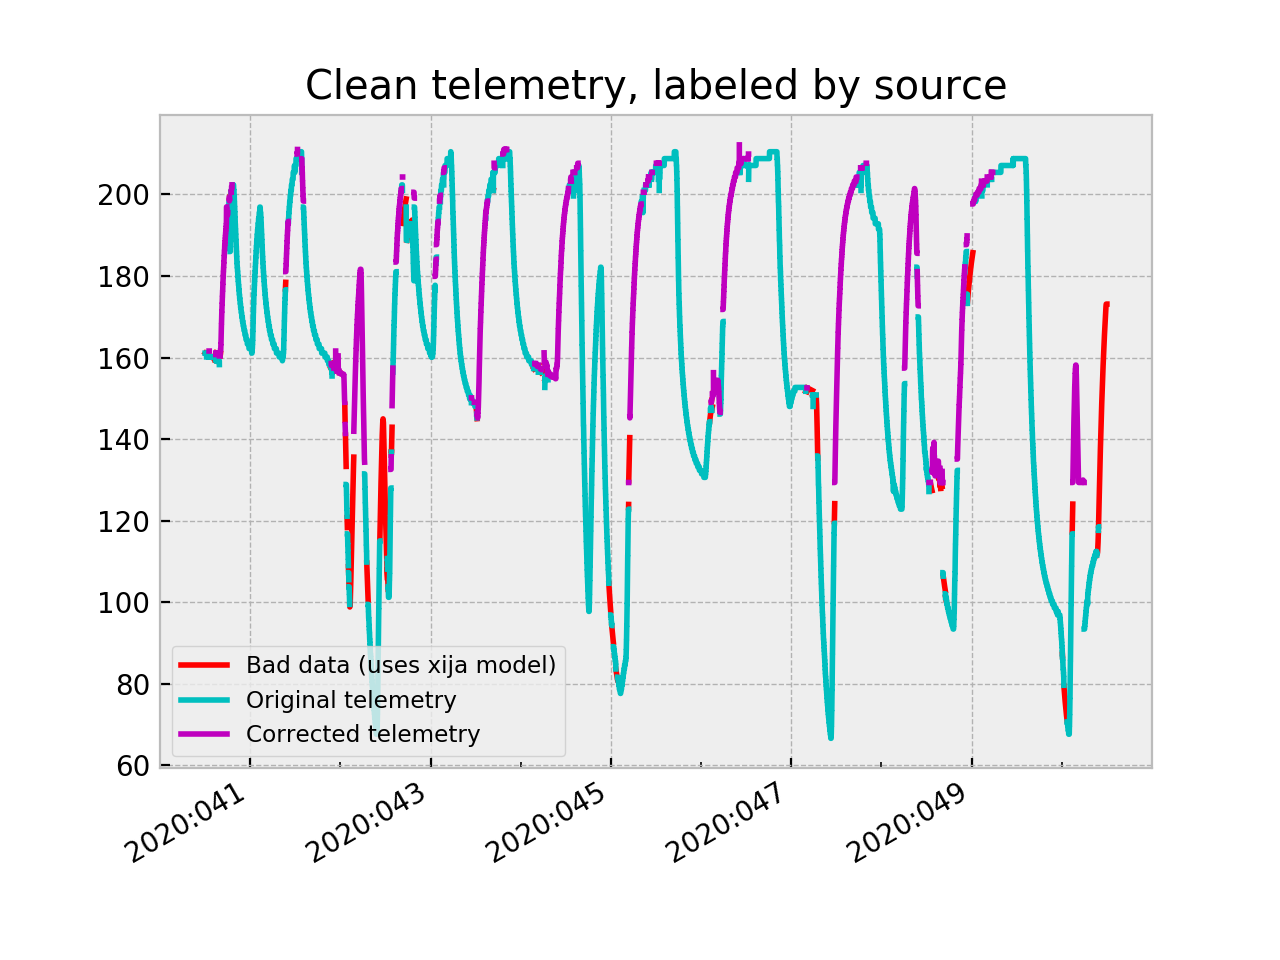

In [7]:
plt.figure()
labels = {0: 'Bad data (uses xija model)', 
          1: 'Original telemetry', 
          2: 'Corrected telemetry'}
for source, color in [(0, 'r'), (1, 'c'), (2, 'm')]:
    ok = (dat.source == source)
    vals = dat.vals.copy()
    vals[~ok] = np.nan
    plot_cxctime(dat.times, vals, label=labels[source], color=color)

plt.legend(fontsize='small');
plt.title('Clean telemetry, labeled by source');

<IPython.core.display.Javascript object>


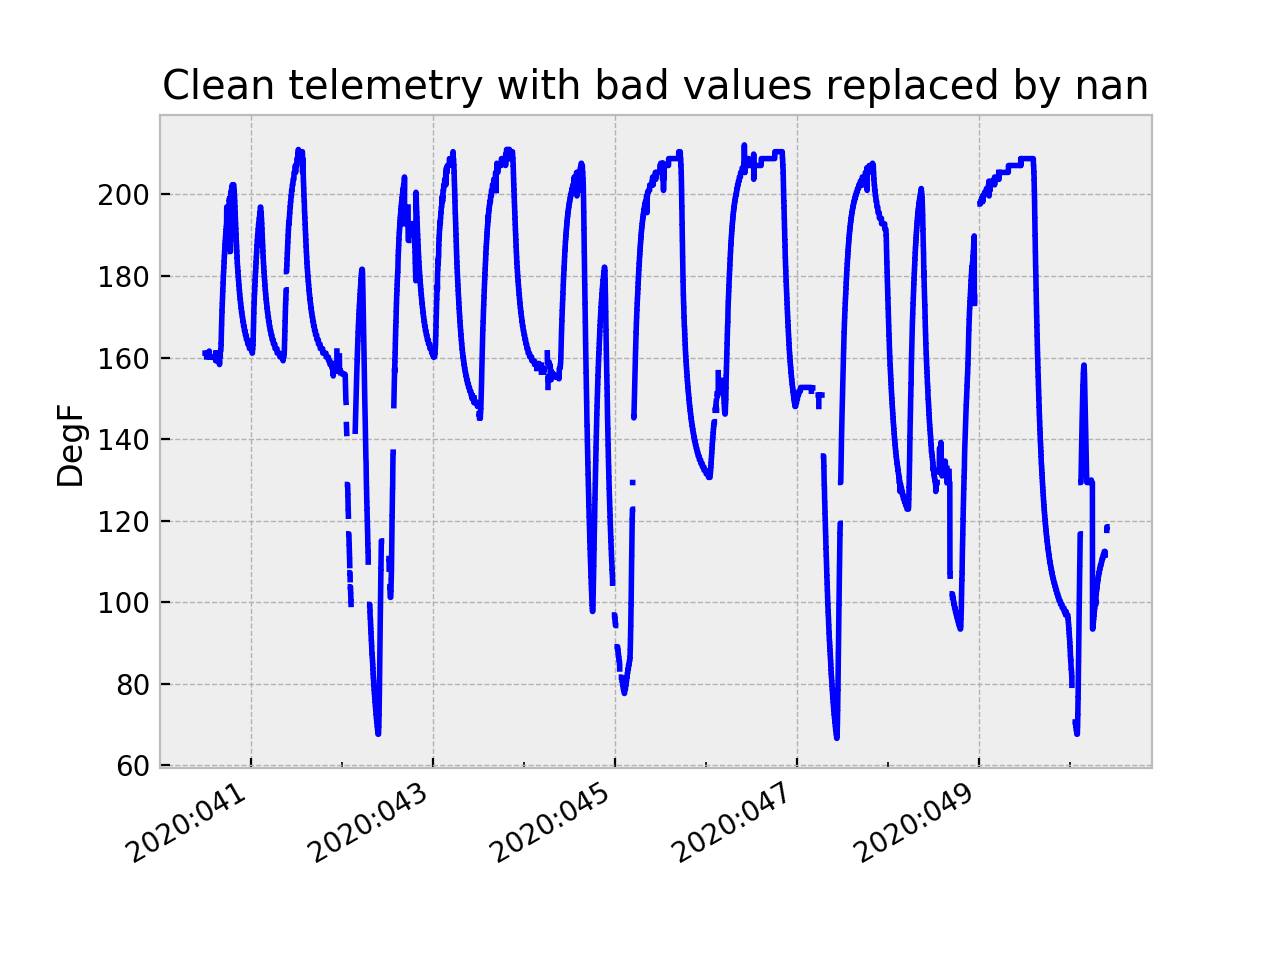

In [8]:
plt.figure()
plot_cxctime(dat.times, dat.vals_nan);
plt.title('Clean telemetry with bad values replaced by nan')
plt.ylabel('DegF');

<IPython.core.display.Javascript object>


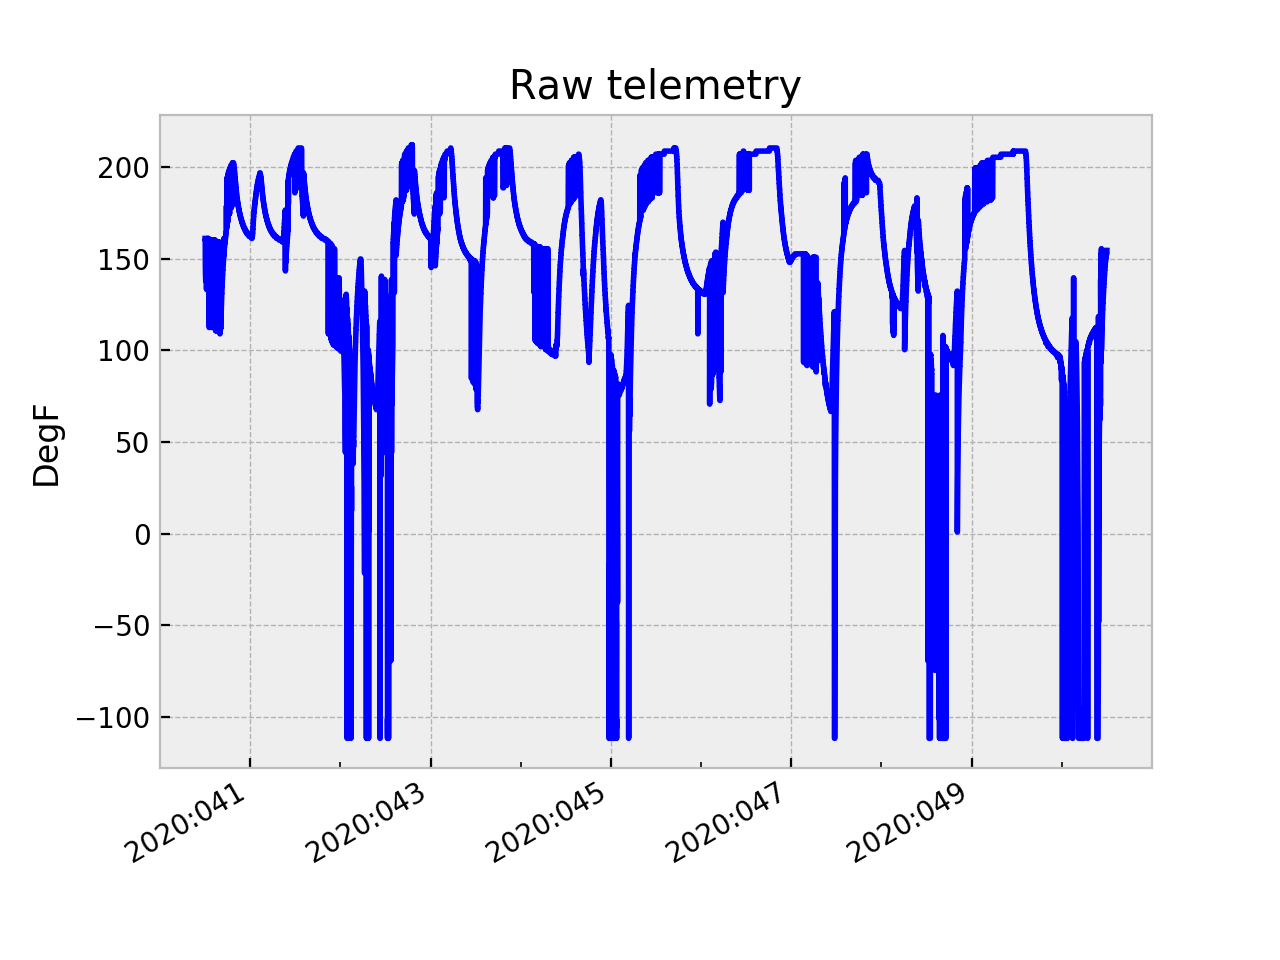

In [9]:
plt.figure()
plot_cxctime(dat.times, dat.vals_raw);
plt.title('Raw telemetry')
plt.ylabel('DegF');

In [10]:
%%time

# Check statistics and performance for a large span of data

dat = fetch_clean_msid('pm2thv1t', '2015:040', '2020:045', dt_thresh=5)
print()
print('Time span = {:.2f} years'.format((dat.tstop - dat.tstart) / 3e7))
print('Valid fraction = {:.3f}'.format(np.count_nonzero(dat.source != 0) / len(dat.vals)))
print('Thermistor not dropped = {:.3f}'.format(np.count_nonzero(dat.source == 1) / len(dat.vals)))
print('Thermistor fully dropped = {:.3f}'.format(np.count_nonzero(dat.source == 2) / len(dat.vals)))
print()

Fetching msid: pm2thv1t over 2015:035:20:28:32.816 to 2020:045:12:20:30.816
Fetching msid: pitch over 2015:035:20:28:32.816 to 2020:045:12:20:30.816
Fetching msid: aoeclips over 2015:035:20:28:32.816 to 2020:045:12:20:30.816
Fetching msid: roll over 2015:035:20:28:32.816 to 2020:045:12:20:30.816

Time span = 5.27 years
Valid fraction = 0.904
Thermistor not dropped = 0.593
Thermistor fully dropped = 0.311

CPU times: user 4.99 s, sys: 1.17 s, total: 6.16 s
Wall time: 6.36 s
